In [1]:
import pandas as pd
import dask.dataframe as dd
import json

import matplotlib
from matplotlib.pyplot import hist
from matplotlib.pyplot import boxplot
import matplotlib.pyplot as plt
import tikzplotlib

%matplotlib inline

In [2]:
def get_domain(url: str) -> str:
    if '//' in url:
        w = url.split('//')[1]
    else:
        w = url
    return w.split('/')[0]

assert get_domain('http://food.com/recipes') == 'food.com'

# Recipe1M+

In [3]:
recipes1M = dd.read_csv('0-datasets/rec1M/rec1M-*.csv')
recipes1M = recipes1M.drop(['Unnamed: 0', 'id', 'partition'], axis=1)
recipes1M = recipes1M.rename(columns={"instructions":"directions", "url":"link"})
recipes1M.ingredients = recipes1M.ingredients.map(json.loads, meta=pd.Series([], dtype=object, name='ingredients'))
recipes1M.directions = recipes1M.directions.map(json.loads, meta=pd.Series([], dtype=object, name='directions'))
recipes1M.ingredients = recipes1M.ingredients.map(lambda x: list(map(lambda y: y['text'], x)), meta=pd.Series([], dtype=object, name='ingredients'))
recipes1M.directions = recipes1M.directions.map(lambda x: list(map(lambda y: y['text'], x)), meta=pd.Series([], dtype=object, name='directions'))
# rec1M_df = recipes1M.compute()
# rec1M_df.head()

In [4]:
rec1M_df = pd.DataFrame(data = {
    'page': recipes1M.link.compute().map(get_domain),
    'ingredients_count': recipes1M.ingredients.map(len).compute(),
    'directions_count': recipes1M.directions.map(len).compute()
})

In [5]:
rec1M_df.agg({
    'page': 'count',
    'ingredients_count': ['min', 'mean', 'median', 'max'],
    'directions_count': ['min', 'mean', 'median', 'max']
})

,page,ingredients_count,directions_count
count,1029720.0,NaN,NaN
max,NaN,99.000000,167.000000
mean,NaN,9.328161,10.456821
median,NaN,9.000000,9.000000
min,NaN,1.000000,1.000000


In [6]:
rec1M_ingr = list(rec1M_df.ingredients_count)
rec1M_inst = list(rec1M_df.directions_count)

# Gathered Data

In [7]:
gathered = dd.read_csv('0-datasets/v-0.9.3-single.csv')
gathered.ingredients = gathered.ingredients.map(json.loads, meta=pd.Series([], dtype=object, name='ingredients'))
gathered.directions = gathered.directions.map(json.loads, meta=pd.Series([], dtype=object, name='directions'))
# gathered = gathered.compute()
# gathered.head()

In [8]:
gathered_df = pd.DataFrame(data = {
    'page': gathered.link.compute().map(get_domain),
    'ingredients_count': gathered.ingredients.map(len).compute(),
    'directions_count': gathered.directions.map(len).compute()
})

In [9]:
gathered_df.agg({
    'page': 'count',
    'ingredients_count': ['min', 'mean', 'median', 'max'],
    'directions_count': ['min', 'mean', 'median', 'max']
})

,page,ingredients_count,directions_count
count,1727646.0,NaN,NaN
max,NaN,407.000000,107.000000
mean,NaN,8.578222,5.220961
median,NaN,8.000000,5.000000
min,NaN,1.000000,1.000000


In [10]:
gathered_ingr = list(gathered_df.ingredients_count)
gathered_inst = list(gathered_df.directions_count)

# Concatenated datasets - deduplicted

In [11]:
total = dd.read_csv('0-datasets/v-1.1.1-single-h.csv')
total.ingredients = total.ingredients.map(json.loads, meta=pd.Series([], dtype=object, name='ingredients'))
total.directions = total.directions.map(json.loads, meta=pd.Series([], dtype=object, name='directions'))
# total = total.compute()
# total.head()

In [12]:
novel = pd.DataFrame(data = {
    'page': total.link.compute().map(get_domain),
    'ingredients_count': total.ingredients.map(len).compute(),
    'directions_count': total.directions.map(len).compute()
})

In [13]:
novel.agg({
    'page': 'count',
    'ingredients_count': ['min', 'mean', 'median', 'max'],
    'directions_count': ['min', 'mean', 'median', 'max']
})

,page,ingredients_count,directions_count
count,2231142.0,NaN,NaN
max,NaN,407.000000,164.000000
mean,NaN,8.727042,6.613628
median,NaN,8.000000,5.000000
min,NaN,1.000000,1.000000


In [14]:
pd.DataFrame(data = {
    'source': total.source.compute(),
    'page': total.link.compute().map(get_domain),
    'ingredients_count': total.ingredients.map(len).compute(),
    'directions_count': total.directions.map(len).compute()
}).groupby('source').agg({
    'page': 'count',
    'ingredients_count': ['min', 'mean', 'median', 'max'],
    'directions_count': ['min', 'mean', 'median', 'max']
})

page ingredients_count                       directions_count  \
             count               min      mean median  max              min   
source                                                                        
Gathered   1643098                 1  8.552038      8  407                1   
Recipes1M   588044                 1  9.216037      9   99                1   

                                  
                mean median  max  
source                            
Gathered    5.220170      5  107  
Recipes1M  10.507193      9  164

# Plot

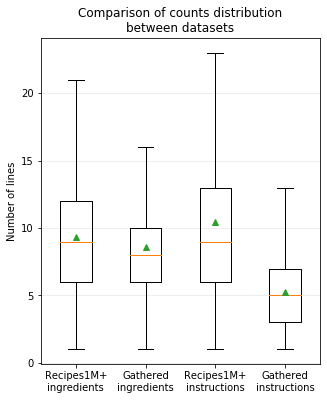

In [15]:
data = [
    rec1M_ingr,
    gathered_ingr,
    rec1M_inst,
    gathered_inst,
]

fig, ax1 = plt.subplots(figsize=(5, 6))
fig.canvas.set_window_title('A Boxplot Example')
# fig.subplots_adjust(left=0.125, right=1, top=0.9, bottom=0.25)

bp = ax1.boxplot(data, notch=0, sym='', vert=1, whis=1.5, showmeans=True)
# plt.setp(bp['boxes'], color='black')
# plt.setp(bp['whiskers'], color='black')
# plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)

# Hide these grid behind plot objects
ax1.set_axisbelow(True)
ax1.set_title('Comparison of counts distribution\nbetween datasets')
# ax1.set_xlabel('Ditribution')
ax1.set_ylabel('Number of lines')

ax1.set_xticklabels(['Recipes1M+\ningredients', 'Gathered\ningredients', 'Recipes1M+\ninstructions', 'Gathered\ninstructions'])

plt.savefig('distr-comparison.png', dpi=600)
tikzplotlib.save('distr-comparison.tex')
plt.show()

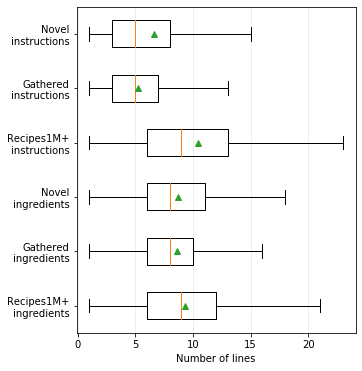

In [16]:
data = [
    rec1M_ingr,
    gathered_ingr,
    list(novel.ingredients_count),
    rec1M_inst,
    gathered_inst,
    list(novel.directions_count),
]

# data.reverse()

fig, ax1 = plt.subplots(figsize=(5, 6))
fig.canvas.set_window_title('A Boxplot Example')
# fig.subplots_adjust(left=0.125, right=1, top=0.9, bottom=0.25)

bp = ax1.boxplot(data, notch=0, sym='', vert=0, whis=1.5, showmeans=True)
# plt.setp(bp['boxes'], color='black')
# plt.setp(bp['whiskers'], color='black')
# plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.xaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)

# Hide these grid behind plot objects
ax1.set_axisbelow(True)
# ax1.set_title('Comparison of counts distribution\nbetween datasets')
# ax1.set_xlabel('Ditribution')
ax1.set_xlabel('Number of lines')

ax1.set_yticklabels(['Recipes1M+\ningredients', 'Gathered\ningredients','Novel\ningredients', 
                     'Recipes1M+\ninstructions', 'Gathered\ninstructions', 'Novel\ninstructions'])

plt.savefig('distr-comparison-horizontal.png', dpi=600)
tikzplotlib.save('distr-comparison-horizontal.tex')
plt.show()